# Group 1 Capstone Project Work
### Make sure to make / checkout your own branch before making changes

# Maddie Hince

In [10]:
import pandas as pd
import sqlite3

df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
df.head()


conn = sqlite3.connect('zippedData/im.db.zip')
pd.read_sql("""SELECT *""")

DatabaseError: Execution failed on sql '
SELECT *
FROM im
': file is not a database

# Cat Murad

# Elijah Soba

Working on: Gross dataset and Movie Budgets dataset

In [82]:
# Import statements
import sqlite3 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

# Gross Dataset

In [83]:
# Define filepath & read in the data 
filepath = 'zippedData/bom.movie_gross.csv.gz'
movie_gross_df = pd.read_csv(filepath)

In [84]:
# Take a prelimary look at the data
movie_gross_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [85]:
# Take a look at the data frame information
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


From looking at the information we can see immediately that there are a couple things wrong with the data:
- There are missing values in studio, domestic gross, and foreign gross
- Foreign gross is represented as an object instead of a float
- Year is represented as an integer, but it is probably better to have it as a datetime object

## Cleaning Step 1: Change Dtypes

We want to be sure that all of the dtypes that we are working with are acurately represented by the correct python type that we expect. Looking at the data frame information, we see that `foreign_gross` is represented as an `object` when we would expect to see it as a `float`. In addition, year is represented as an `int` when we would expect it to be a `datetime` object. We can use Pandas to change this data to meet our data type expectations

In [86]:
# Lets recast foregin_gross as a float 
str_to_float = lambda x: float(str(x).replace(',', ''))
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].map(str_to_float)

In [87]:
# Lets test to see if the data type actually changed 
assert movie_gross_df['foreign_gross'].dtype  == np.float64

In [88]:
# Lets recast year as a datetime object 
movie_gross_df['year'] = pd.to_datetime(movie_gross_df['year'], format='%Y')

In [89]:
# Lets test to see if this worked
assert movie_gross_df['year'].dtype != np.int64

## Cleaning Step 2: Handle Missing Data

First, we look at the `studio` column because that is the column with the least amount of missing data. In addition, it is the easiest to deal with because missing values can be replaced with 'IND' standing for independent film 

Next, we look at the `domestic_gross` column which is one of the primary sources of data in this table. We check to see what percentage of the data is corrupted, and if it is small we will simply delete those rows. If it is not, we will explore data imputation techniques

Finally, we look at the `foreign_gross` column and perform the same analysis as the `domestic_gross`. Seeing that it is a big chunk of the data, we will most likely have to impute. Imputation can be done by looking at a summary statistic of the percent change between `foreign_gross` and `domestic_gross` and using that to make up a value for `foreign gross` as a function of `domestic_gross`. 


In [90]:
# Lets replace missing studios with 'IND' representing independent
movie_gross_df['studio'] = movie_gross_df['studio'].fillna('IND')

In [91]:
# Test to see if there are any missing values in the studio column
assert movie_gross_df['studio'].isna().sum() == 0

In [92]:
# Lets see what percentage of the domestic gross data is missing 
pct_missing_dom = movie_gross_df.domestic_gross.isna().sum()/len(movie_gross_df.title)
print(f'Missing domestic gross data represents {pct_missing_dom*100}% of the data')

Missing domestic gross data represents 0.8266902863891349% of the data


In [93]:
# The missing data is a very small fraction, so lets delete those rows
movie_gross_df = movie_gross_df.dropna(axis=0, subset=['domestic_gross'])

In [94]:
# Test to see whether that deletion worked
assert movie_gross_df['domestic_gross'].isna().sum() == 0

In [95]:
# Lets see what percentage of the foreign gross data is missing 
pct_missing_dom = movie_gross_df.foreign_gross.isna().sum()/len(movie_gross_df.title)
print(f'Missing domestic gross data represents {pct_missing_dom*100}% of the data')

Missing domestic gross data represents 40.190532896695444% of the data


In [96]:
# That is too much, so lets find the median pct change between domestic and foreign films
med_pct_change = ((movie_gross_df['foreign_gross'] - movie_gross_df['domestic_gross'])/movie_gross_df['domestic_gross']).median()
print(med_pct_change)

0.6315266036797613


In [97]:
# Now that we have the median % change, lets impute the missing foreign values 
impute_change = movie_gross_df['domestic_gross'] + (movie_gross_df['domestic_gross'] * med_pct_change)
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].fillna(impute_change)

In [98]:
# Test that we now have no more NaN values in the data 
assert movie_gross_df['foreign_gross'].isna().sum() == 0

In [99]:
# Finally, test to see if there are any missing values anywhere in the data 
assert movie_gross_df.isna().sum().sum() == 0

## Data Exploration: 

Now that we do not have any more missing values, we can begin data exploration. Because we want to see what contributes to a successful movie, we can look at how gross changes depending on different factors such as year and studio. In addition, we can explore the relationships within and between these variables to see if any meaningful conclusions can be drawn.

## Step 1: Explore Values in the Gross Columns

In [100]:
# Lets feature engineer a new feature that can be useful to our understanding of gross as a whole
movie_gross_df['total_gross'] = movie_gross_df['foreign_gross'] + movie_gross_df['domestic_gross']

In [101]:
# Test to see whether that column was successfully created 
assert 'total_gross' in movie_gross_df.columns

In [102]:
# Lets take a look at that newly created column 
movie_gross_df['total_gross'].sort_values()

1476    2.631527e+02
2757    7.894580e+02
2756    7.894580e+02
2321    7.894580e+02
3078    1.052611e+03
            ...     
2758    1.332600e+09
328     1.341500e+09
3080    1.347000e+09
1875    1.405400e+09
727     1.518900e+09
Name: total_gross, Length: 3359, dtype: float64

In [103]:
# Lets normalize the data to millions to make numbers more manageable
movie_gross_df['total_gross'] = movie_gross_df['total_gross']/1000000
movie_gross_df['domestic_gross'] = movie_gross_df['domestic_gross']/1000000
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross']/1000000

In [104]:
# Lets take another look 
movie_gross_df['total_gross'].sort_values()

1476       0.000263
2757       0.000789
2756       0.000789
2321       0.000789
3078       0.001053
           ...     
2758    1332.600000
328     1341.500000
3080    1347.000000
1875    1405.400000
727     1518.900000
Name: total_gross, Length: 3359, dtype: float64

In [105]:
# Lets see what movie grossed the most 
movie_gross_df.loc[movie_gross_df['total_gross'].idxmax(), :]

title             Marvel's The Avengers
studio                               BV
domestic_gross                    623.4
foreign_gross                     895.5
year                2012-01-01 00:00:00
total_gross                      1518.9
Name: 727, dtype: object

In [106]:
# Lets see what film did the best in terms of domestic gross 
movie_gross_df.loc[movie_gross_df['domestic_gross'].idxmax(), :]

title             Star Wars: The Force Awakens
studio                                      BV
domestic_gross                           936.7
foreign_gross                        0.0011316
year                       2015-01-01 00:00:00
total_gross                            936.701
Name: 1872, dtype: object

In [107]:
# Lets see what film did the best in terms of foreign gross 
movie_gross_df.loc[movie_gross_df['foreign_gross'].idxmax(), :]

title             Harry Potter and the Deathly Hallows Part 2
studio                                                     WB
domestic_gross                                            381
foreign_gross                                           960.5
year                                      2011-01-01 00:00:00
total_gross                                            1341.5
Name: 328, dtype: object

<AxesSubplot:ylabel='Frequency'>

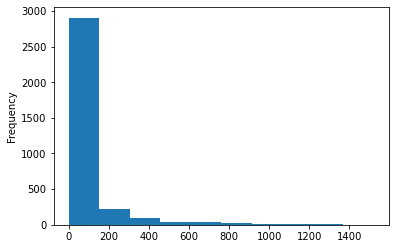

In [108]:
# Lets visualize the distribution of total gross data 
movie_gross_df['total_gross'].plot.hist()

<AxesSubplot:xlabel='domestic_gross', ylabel='foreign_gross'>

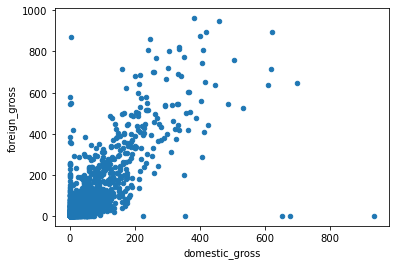

In [109]:
# Lets visually see the correlation between domestic and foreign gross
movie_gross_df.plot.scatter('domestic_gross', 'foreign_gross')

By looking at the scatter plot, we can notice two main things. 
- There is a positive correlation between domestic gross and foreign gross which is expected 
- There are a lot of data points that seemingly have 0 domestic gross and non-zero foreign gross (and vice versa)

In [110]:
# Lets quickly verify that there are no films with 0 domestic gross 
assert movie_gross_df[movie_gross_df['domestic_gross'] == 0.0].sum()[0] == 0

In [111]:
# Lets quickly verify that there are no films with 0 domestic gross 
assert movie_gross_df[movie_gross_df['foreign_gross'] == 0.0].sum()[0] == 0

## Step 2: Looking at the Gross Data over time

In [112]:
# Lets see which years are represented in the data
movie_gross_df['year'].value_counts()

2015-01-01    449
2016-01-01    433
2011-01-01    397
2012-01-01    393
2014-01-01    391
2013-01-01    345
2010-01-01    323
2017-01-01    320
2018-01-01    308
Name: year, dtype: int64

<AxesSubplot:xlabel='year', ylabel='domestic_gross'>

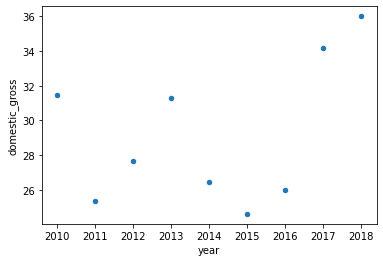

In [113]:
# Lets see how the average domestic gross varied over the years 
movie_gross_df.groupby('year').mean().reset_index().plot.scatter('year', 'domestic_gross')

<AxesSubplot:xlabel='year', ylabel='foreign_gross'>

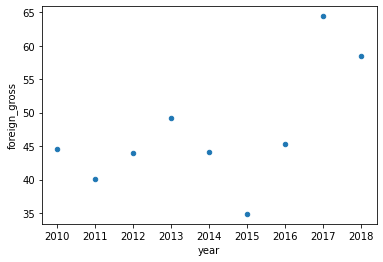

In [114]:
# Lets see how the average foreign gross varied over the years 
movie_gross_df.groupby('year').mean().reset_index().plot.scatter('year', 'foreign_gross')

<AxesSubplot:xlabel='year', ylabel='total_gross'>

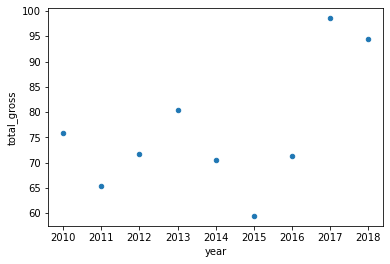

In [115]:
# Lets see how the average total gross varied over the years 
movie_gross_df.groupby('year').mean().reset_index().plot.scatter('year', 'total_gross')

## Step 3: How Well Did Specific Studios Do?

In [116]:
# Lets inspect all of the studios to see if there is any duplicates w/misspellings
movie_gross_df['studio'].value_counts().sort_values(ascending=False)

IFC      166
Uni.     147
WB       140
Magn.    136
Fox      136
        ... 
DR         1
BSC        1
CLF        1
NAV        1
Asp.       1
Name: studio, Length: 256, dtype: int64

<AxesSubplot:xlabel='studio'>

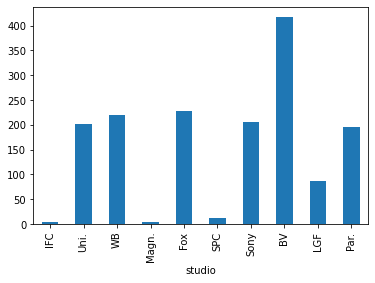

In [117]:
# Lets see how the top 10 most producing studios did in terms of average total gross
top10_prod = list(movie_gross_df['studio'].value_counts().sort_values(ascending=False)[:10].index)
movie_gross_df.groupby('studio').mean()['total_gross'].loc[top10_prod].plot.bar()

<AxesSubplot:xlabel='studio'>

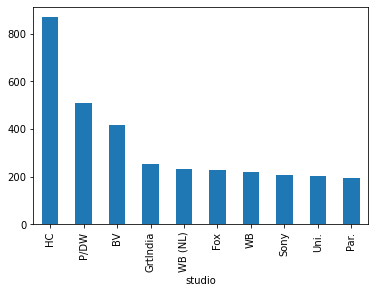

In [118]:
# Instead, lets use the top 10 highest earners
movie_gross_df.groupby('studio').mean()['total_gross'].sort_values(ascending=False)[:10].plot.bar()

In [122]:
movie_gross_df.groupby('studio').count()['title'] > 5

studio
3D       False
A23      False
A24       True
ADC      False
AF        True
         ...  
XL       False
YFG      False
Yash      True
Zee      False
Zeit.     True
Name: title, Length: 256, dtype: bool

# Budget Dataset

In [125]:
# Load in the data into pandas
filepath = 'zippedData/tn.movie_budgets.csv.gz'
budget_df = pd.read_csv(filepath)

In [126]:
# Lets take a glimpse at the data set 
budget_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [127]:
# Take a look at the data frame information
budget_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


From looking at the information we can immediately see a few important things:
- There are no missing values
- The release date is a string and not a datetime object 
- All of the numerical columns are strings instead of floats
- We have an id column


## Data Cleaning 

Because there is no missing data, our cleaning step will involve changing the dtype of all the variables to match our expectations, checking to see if there are any placeholder values that replace NaNs, and normalizing the data to the millions so that the numbers are more manageable

In [128]:
# Lets define a function that will parse through a string of $xxx,xxx,xxx and turn it into a float
money_to_float = lambda x: float(x.replace('$','').replace(',',''))

In [129]:
# Lets test to make sure this function is behaving the way that we anticipate
assert money_to_float('$1,000') == 1000

In [130]:
# Update the dtype of the production_budget column 
budget_df['production_budget'] = budget_df['production_budget'].map(money_to_float)

In [131]:
# Update the dtype of the domestic_gross column 
budget_df['domestic_gross'] = budget_df['domestic_gross'].map(money_to_float)

In [132]:
# Update the dtype of the worldwide_gross column 
budget_df['worldwide_gross'] = budget_df['worldwide_gross'].map(money_to_float)

In [133]:
# Test to make sure it worked
assert budget_df['production_budget'].dtype == np.float64

In [134]:
# Lets make the release date an int dtype that only has the year
budget_df['release_date'] = pd.to_datetime(budget_df['release_date']).dt.year

In [135]:
# Test to make sure the dtype is now correct
assert budget_df['release_date'].dtype == np.int64

In [136]:
# Lets see if any of the gross values are equal to 0, a number that does not make sense in this context
budget_df[budget_df['domestic_gross'] == 0]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
194,95,2020,Moonfall,150000000.0,0.0,0.0
479,80,2017,Bright,90000000.0,0.0,0.0
480,81,2019,Army of the Dead,90000000.0,0.0,0.0
535,36,2020,Call of the Wild,82000000.0,0.0,0.0
617,18,2012,AstÃ©rix et ObÃ©lix: Au service de Sa MajestÃ©,77600000.0,0.0,60680125.0
...,...,...,...,...,...,...
5761,62,2014,Stories of Our Lives,15000.0,0.0,0.0
5764,65,2007,Tin Can Man,12000.0,0.0,0.0
5771,72,2015,Family Motocross,10000.0,0.0,0.0
5777,78,2018,Red 11,7000.0,0.0,0.0


In [137]:
# Lets see if any of the production values are equal to 0, a number that does not make sense in this context
budget_df[budget_df['production_budget'] == 0]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross


We see that there are indeed values that can be considered corrupted in the gross columns, but not in the production column. What we can do with this is see what percentage of data is 0 from the domestic_gross and worldwide_gross. If it is a small percentage, we can just drop the values but if it is a large percentage we can find a way to impute it. 

In [138]:
# Lets see the profile of our "missing" gross values
either_miss = len(budget_df[(budget_df['domestic_gross'] == 0) | (budget_df['worldwide_gross'] == 0)])
both_miss = len(budget_df[(budget_df['domestic_gross'] == 0) & (budget_df['worldwide_gross'] == 0)])
just_dom = len(budget_df[budget_df['domestic_gross'] == 0])
just_world = len(budget_df[budget_df['worldwide_gross'] == 0])
len_dataset = len(budget_df['domestic_gross'])
print(either_miss)
print(both_miss)
print(just_dom)
print(just_world)
print(len_dataset)

548
367
548
367
5782


In [139]:
# Because there are numbers with 0 domestic and worldwide gross, lets see what fraction of the dataset it is
pct_0_dom = just_dom/len_dataset
print(pct_0_dom*100)
pct_0_world = just_world/len_dataset
print(pct_0_world*100)

9.47768938083708
6.347284676582497


In [140]:
# Both values are < 10% of the data, which for now we will consider as small enough to just drop
budget_df = budget_df[budget_df['domestic_gross'] != 0]

In [141]:
# Test to make sure we dropped correctly
assert len(budget_df[budget_df['domestic_gross'] == 0]) == 0
assert len(budget_df[budget_df['worldwide_gross'] == 0]) == 0

In [142]:
# Finally, we can normalize monetary columns to the millions 
budget_df['production_budget'] = budget_df['production_budget']/1000000
budget_df['domestic_gross'] = budget_df['domestic_gross']/1000000
budget_df['worldwide_gross'] = budget_df['worldwide_gross']/1000000

## Data Exploration

Now that all of the data types are what we expect, we will explore the data. First, we look at the `id` column to see what relevance it has to the dataset. Then, we will create some features to explore the relationship between a movies budget and how much it grosses both domestically and worldwide. Finally, we will look at the data over time to see if older movies would give our clients outdated information. 

## Step 1: What do the ID's mean?

In [143]:
# Lets look at the value counts for the id's 
budget_df['id'].value_counts()

79    56
77    55
47    55
78    55
37    55
      ..
63    49
55    49
62    49
95    49
56    47
Name: id, Length: 100, dtype: int64

It looks like each of the ID's have the same number of entries meaning that there could be something more to them than it seems. Lets take a quick look at some of the respective index values to see if maybe groups have something in common

In [144]:
# Investigate group 4
budget_df[budget_df['id'] == 4].head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
3,4,2015,Avengers: Age of Ultron,330.6,459.005868,1403.013963
103,4,2009,Monsters vs. Aliens,175.0,198.351526,381.687380
203,4,2016,Ghostbusters,144.0,128.350574,229.008658
303,4,1999,Star Wars Ep. I: The Phantom Menace,115.0,474.544677,1027.044677
403,4,2018,Mortal Engines,100.0,15.951040,85.287417
503,4,2006,Open Season,85.0,85.105259,191.932158
603,4,1997,The Postman,80.0,17.650704,20.841123
703,4,2003,S.W.A.T.,70.0,116.877597,207.154748
803,4,2012,Resident Evil: Retribution,65.0,42.345531,240.647629
903,4,2013,Gangster Squad,60.0,46.000903,104.100903


In [145]:
# Investigate group 8
budget_df[budget_df['id'] == 8].head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
7,8,2007,Pirates of the Caribbean: At Worldâs End,300.0,309.420425,963.420425
107,8,2008,The Mummy: Tomb of the Dragon Emperor,175.0,102.491776,405.760225
207,8,1998,Armageddon,140.0,201.578182,554.600000
307,8,2013,The Wolverine,115.0,132.556852,416.456852
407,8,2019,The LEGO Movie 2: The Second Part,99.0,105.806508,190.325698
507,8,2006,The Holiday,85.0,63.280000,205.190324
607,8,2005,A Sound of Thunder,80.0,1.900451,6.300451
707,8,1997,Hercules,70.0,99.112101,250.700000
807,8,1996,The Long Kiss Goodnight,65.0,33.447612,33.447612
907,8,2010,Edge of Darkness,60.0,43.313890,82.812456


The only similarity between the two groups is that production budgets seem to line up in similar decreasing fashions. This most likely means all of this data was ordered by production_budget and each group was concatenated with each other to make one big dataset. Until we receive any new information, let us just not worry about the ID column. 

## Step 2: How do Old Movies Compare to Newer Movies?

In [146]:
# First, lets look at the highest grossing films worldwide and domestic
print(budget_df.loc[budget_df['worldwide_gross'].idxmax(), :])
print(budget_df.loc[budget_df['domestic_gross'].idxmax(), :])

id                         1
release_date            2009
movie                 Avatar
production_budget        425
domestic_gross       760.508
worldwide_gross      2776.35
Name: 0, dtype: object
id                                                      6
release_date                                         2015
movie                Star Wars Ep. VII: The Force Awakens
production_budget                                     306
domestic_gross                                    936.662
worldwide_gross                                   2053.31
Name: 5, dtype: object


In [147]:
# Lets look at the value count of all the years
budget_df['release_date'].value_counts().sort_index(ascending=False)

2019     44
2018    137
2017    149
2016    192
2015    208
       ... 
1929      1
1925      2
1920      1
1916      1
1915      1
Name: release_date, Length: 92, dtype: int64

<AxesSubplot:>

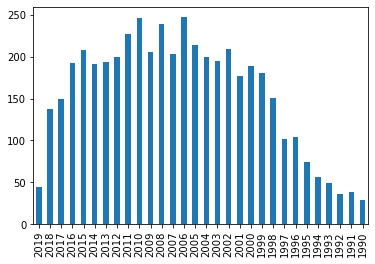

In [148]:
# Already we can see some years have very little movies. Let us filter the top 30 
budget_df['release_date'].value_counts().sort_index(ascending=False)[:30].plot.bar()

It seems like after 1997 there was a big boom in the number of movies that were made. From the standpoint of quantity of movies, there is no indication that we should only look at a more recent subset. Lets check out how much movies grossed based on year starting with the year that the boom happened

In [149]:
# Lets filter out the older dates
budget_df = budget_df[budget_df['release_date'] > 1997]

In [150]:
# Check our new filtered years
budget_df['release_date'].value_counts()

2006    247
2010    246
2008    239
2011    227
2005    214
2002    209
2015    208
2009    205
2007    203
2004    200
2012    200
2003    195
2013    193
2016    192
2014    191
2000    189
1999    181
2001    177
1998    151
2017    149
2018    137
2019     44
Name: release_date, dtype: int64

<AxesSubplot:xlabel='release_date', ylabel='worldwide_gross'>

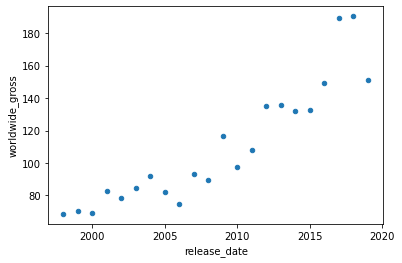

In [152]:
# Lets groupby the year and see the median amount movies grossed worldwide
budget_df.groupby('release_date').mean().reset_index().plot.scatter('release_date', 'worldwide_gross')

From the graph, it is obvious that there is an upward trend in worldwide gross over the years. Because we know our other dataset starts movie data at 2010 and after 2010 the worldwide gross is higher than the years prior by a substantial margin, we can consider deleting those years prior.

In [66]:
# Remove the years before 2010 where we saw a jump in worldwide gross
budget_df = budget_df[budget_df['release_date'] >= 2010]

## Step 3: How does Production Budget Affect Gross?

<AxesSubplot:xlabel='production_budget', ylabel='worldwide_gross'>

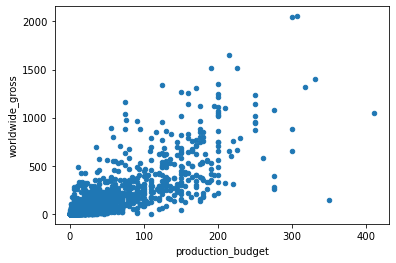

In [68]:
# Lets start off by checking the scatter plot of budget and worldwide gross to gain intuition
budget_df.plot.scatter('production_budget', 'worldwide_gross')

In [71]:
# To be more concrete, lets also print out the correlation coefficient 
np.corrcoef(budget_df['production_budget'], budget_df['worldwide_gross'])[0][1]

0.7872721892906527

From the scatter plot, it looks like there is a positive correlation (.787) but not as much as we would expect. This indicates that spending more money on a film may not mean more gross 

<AxesSubplot:ylabel='Frequency'>

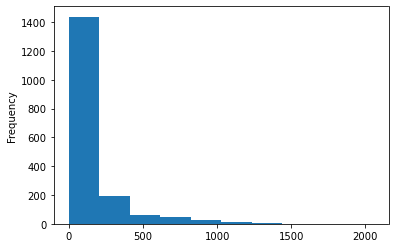

In [69]:
# Lets look at the distribution of worldwide gross to see how it is shaped 
budget_df['worldwide_gross'].plot.hist()

It seems like a majority of films fall into the same bucket, but we want to give a suggestions that will get our movie studio into the tail end of the distribution. Lets see if the production budget can give us more information related to this

In [160]:
# Lets define a feature called budget to gross ratio 
budget_df['bg_ratio'] = budget_df['worldwide_gross']/budget_df['production_budget']
budget_df.bg_ratio.head()

0    6.532577
1    2.546673
2    0.427892
3    4.243841
4    4.153696
Name: bg_ratio, dtype: float64

This ratio can be interpreted as "for every dollar spent on production, how much did it gross worldwide?"

<AxesSubplot:ylabel='Frequency'>

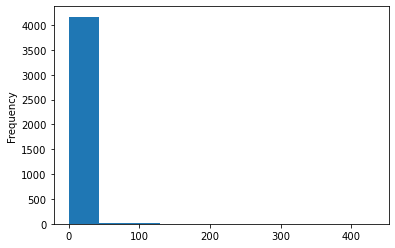

In [161]:
# Lets look at the distribution of the bg ratio
budget_df['bg_ratio'].plot.hist()

<AxesSubplot:ylabel='movie'>

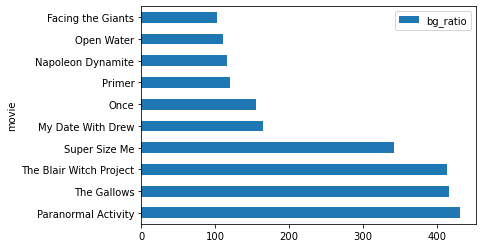

In [162]:
# It looks like there is are some outliers, lets see the top 10 best films in terms of bg_ratio
budget_df.sort_values(by='bg_ratio', ascending=False)[:10].plot.barh('movie', 'bg_ratio')

Off first glance it seems like a lot of these are horror films, indicating that the best bang for your buck is to do horror.

In [163]:
# Lets give some ordinality to our budgets to define low budget and high budget movies
avg_budget = budget_df['production_budget'].mean()
avg_budget

37.39333318084346

In [164]:
# Create a column that represents high budget and low budget movies
budget_df['high_budget'] = (budget_df['production_budget'] > avg_budget).astype(int)

<AxesSubplot:xlabel='high_budget'>

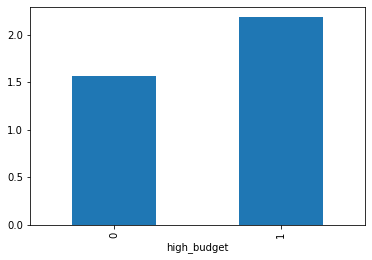

In [167]:
# Lets see the average and median bg_ratio for high budget and low budget films
budget_df.groupby('high_budget').median()['bg_ratio'].plot.bar()

<AxesSubplot:xlabel='high_budget'>

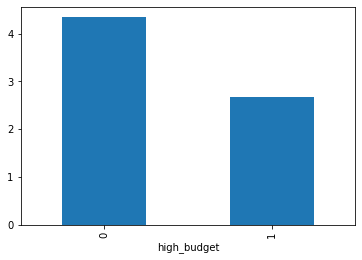

In [168]:
budget_df.groupby('high_budget').mean()['bg_ratio'].plot.bar()

We can see that there is a difference between mean and median, and it likely has to do with the fact that there are some very highly grossing movies that spent basically nothing on production. Maybe we can do a hypothesis test here to determine if bg_ratio mean is significantly different? 

In [169]:
# Lets see if the variances are equal 
budget_df.groupby('high_budget').var()

,id,release_date,production_budget,domestic_gross,worldwide_gross,bg_ratio
high_budget,,,,,,
0,816.391252,32.609952,111.062855,970.819247,3449.031944,306.627911
1,823.278158,35.528362,2676.252320,9985.159605,74423.551400,4.697645


The variances are not equal at all (most likely due to the outliers) so maybe a t test here is not appropriate. 

# IMDB Database

# Luis Estrada 

# Kilmar Lazo 

# Michael Eugene